In [ ]:
!nvidia-smi

Mon Oct 26 07:16:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5MB 2.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyts.image import GramianAngularField
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam

In [ ]:
df = pd.read_table('INDELHI.txt', sep='[ ]*', names=('Month', 'Day', 'Year','Temperature'))
df=df.drop(['Month','Day','Year'],axis=1)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:755: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())
/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:2535: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:2538: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,Temperature
0,50.7
1,52.1
2,53.8
3,53.7
4,54.5


In [ ]:
lis=[]
for index,rows in df.iterrows():
    if rows[0]==-99:
      rows[0]==0
      lis.append(index)
        

In [ ]:
for i in lis:
  df.iloc[i][0]=df.iloc[i-1][0]


9265


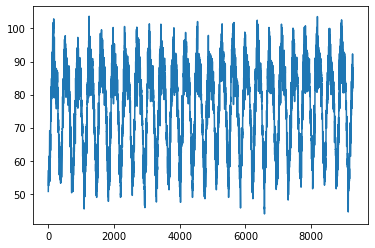

In [ ]:
lit=[]
for index,rows in df.iterrows():
    lit.append(rows[0])
print(len(lit))
plt.plot(lit)

In [ ]:
def images(data,lookback,min_index,max_index):
    batches=max_index-lookback-min_index
    a=np.zeros((batches,lookback))
    b=np.zeros(batches)
    index=min_index+lookback
    while True:
        if index>=max_index:
            break
        for i in range(batches):
            a[i]=data[index-lookback:index]
            b[i]=data[index]
            index+=1
    return a,b

In [ ]:
train_image,train_label =images(lit,400,0,7413)
v_image,v_label=images(lit,400,7413,8339)
test_image,test_label=images(lit,400,8339,9265)


In [ ]:
train_image.shape

(7013, 400)

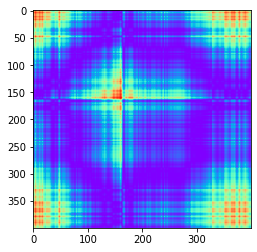

In [ ]:
gasf = GramianAngularField(image_size=400, method='summation')
gadf = GramianAngularField(image_size=400, method='difference')
X_gasf_train = gasf.fit_transform(train_image[5].reshape(1, -1))
plt.imshow(X_gasf_train[0],cmap='rainbow')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir('drive/My Drive/TIME_SERIES_DATA(DELHI)')

['VALIDATION_DATA', 'TEST_DATA', 'TRAIN_DATA']

In [ ]:
def image_saver(data):
    for i in range(data.shape[0]):
        X_gasf_train = gasf.fit_transform(train_image[i].reshape(1, -1))
        plt.imsave('/content/drive/My Drive/TIME_SERIES_DATA(DELHI)/TRAIN_DATA/SUMMATION/{}.jpg'.format(i),X_gasf_train[0],cmap='rainbow')

In [ ]:
def image_saver_val(data):
    for i in range(data.shape[0]):
        X_gasf_val = gasf.fit_transform(v_image[i].reshape(1, -1))
        plt.imsave('/content/drive/My Drive/TIME_SERIES_DATA(DELHI)/VALIDATION_DATA/SUMMATION/{}.jpg'.format(i),X_gasf_val[0],cmap='rainbow')

In [ ]:
image_saver(train_image)
image_saver_val(v_image)

In [ ]:
def dataframe_generator(image,label,type_data,tvt):
    df=pd.DataFrame(columns=['PATH'])
    for i in range(len(image)):
        df=df.append({'PATH':'TIME_SERIES_DATA(DELHI)/{}/{}/{}.jpg'.format(tvt,type_data,i)},ignore_index=True)
    df['Value']=label
    return df

In [ ]:
train_sum=dataframe_generator(train_image,train_label,'SUMMATION','TRAIN_DATA')
#train_diff=dataframe_generator(train_image,train_label,'DIFFERENCE','TRAIN_DATA')
val_sum=dataframe_generator(v_image,v_label,'SUMMATION','VALIDATION_DATA')
#val_diff=dataframe_generator(v_image,v_label,'DIFFERENCE','VALIDATION_DATA')
test_sum=dataframe_generator(test_image,test_label,'SUMMATION','TEST_DATA')
#test_diff=dataframe_generator(test_image,test_label,'DIFFERENCE','TEST_DATA')

In [ ]:
train_sum.tail()

,PATH,Value
7008,TIME_SERIES_DATA(DELHI)/TRAIN_DATA/SUMMATION/7...,79.5
7009,TIME_SERIES_DATA(DELHI)/TRAIN_DATA/SUMMATION/7...,81.7
7010,TIME_SERIES_DATA(DELHI)/TRAIN_DATA/SUMMATION/7...,77.4
7011,TIME_SERIES_DATA(DELHI)/TRAIN_DATA/SUMMATION/7...,82.4
7012,TIME_SERIES_DATA(DELHI)/TRAIN_DATA/SUMMATION/7...,86.4


In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_dataframe(dataframe=train_sum, directory='/content/drive/My Drive', 
                                              x_col="PATH", y_col="Value", has_ext=True, 
                                              class_mode="other", shuffle=False,target_size=(400, 400), 
                                              batch_size=10)
v_generator=datagen.flow_from_dataframe(dataframe=val_sum, directory='/content/drive/My Drive', 
                                              x_col="PATH", y_col="Value", has_ext=True, 
                                              class_mode="other", shuffle=False, target_size=(400, 400), 
                                              batch_size=10)

In [ ]:
from keras.layers import Input
new_input = Input(shape=(400, 400, 3))

In [ ]:
conv_base=VGG16(include_top=False,input_tensor=new_input)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0     

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adagrad',
              loss='huber',
              metrics=['mae','mean_absolute_percentage_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 12, 12, 512)       14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 73729     
Total params: 14,788,417
Trainable params: 14,788,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_checkpoint = ModelCheckpoint('timeseriesmodel.hdf5',
                                   monitor='val_mae',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')
model.fit(train_generator,steps_per_epoch=233*3,epochs=10,validation_data=v_generator,validation_steps=16*3, callbacks=[model_checkpoint])

Epoch 1/10
699/699 [==============================] - ETA: 0s - loss: 9.9206 - mae: 10.4059 - mean_absolute_percentage_error: 14.3529
Epoch 00001: val_mae improved from inf to 3.31026, saving model to timeseriesmodel.hdf5
699/699 [==============================] - 1410s 2s/step - loss: 9.9206 - mae: 10.4059 - mean_absolute_percentage_error: 14.3529 - val_loss: 2.8438 - val_mae: 3.3103 - val_mean_absolute_percentage_error: 4.0804
Epoch 2/10
699/699 [==============================] - ETA: 0s - loss: 3.6996 - mae: 4.1739 - mean_absolute_percentage_error: 5.6405
Epoch 00002: val_mae improved from 3.31026 to 3.26349, saving model to timeseriesmodel.hdf5
699/699 [==============================] - 184s 263ms/step - loss: 3.6996 - mae: 4.1739 - mean_absolute_percentage_error: 5.6405 - val_loss: 2.7962 - val_mae: 3.2635 - val_mean_absolute_percentage_error: 3.9773
Epoch 3/10
699/699 [==============================] - ETA: 0s - loss: 3.2516 - mae: 3.7223 - mean_absolute_percentage_error: 5.0115


In [ ]:
model1=models.load_model("timeseriesmodel.hdf5")

In [ ]:
prediction=model1.predict(v_generator,steps=16*3)
prediction.shape

(480, 1)

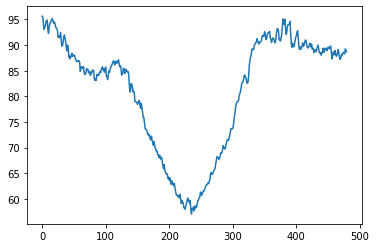

In [ ]:
plt.plot(prediction)

In [ ]:
actual=val_sum['Value'][:480]

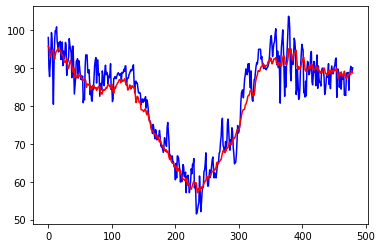

In [ ]:
plt.plot(actual,'b')
plt.plot(prediction,'r')